In [1]:
%run ../Commons.ipynb

## Config your environment and agent

### TODO: Define the environment

In [2]:
# Create a mutated environment
from gym.envs.classic_control import CartPoleEnv
from types import SimpleNamespace

class MutatedCartPoleEnv(CartPoleEnv):
    def __init__(self, masscart = 1.0, masspole = 0.1, length = 0.5, force_mag = 10.0):
        super().__init__()
        
        self.spec = SimpleNamespace()
        self.spec.id = f"MutatedCartPole-{masscart:.3f}-{masspole:.3f}-{length:.3f}-{force_mag:.3f}"
        
        self.gravity = 9.8
        self.masscart = masscart
        self.masspole = masspole
        self.total_mass = self.masspole + self.masscart
        self.length = length  # actually half the pole's length
        self.polemass_length = self.masspole * self.length
        self.force_mag = force_mag
        self.tau = 0.02  # seconds between state updates
    
    def reset_to(self, state, seed=None):
        self.seed(seed)
        self.state = state
        self.steps_beyond_done = None
        return np.array(self.state, dtype=np.float32)

In [3]:
masscart = [0.1, 2.0]
force_mag = [1.0, 20.0]

# define the range of the deviation parameters
dev_bounds = np.asarray([masscart, force_mag])

# define the range of the variables to falsify
falsify_range = np.repeat([[-0.05, 0.05]], 4, axis=0)

# define the deviation parameter value for the original environment (no deviation)
x_original = np.asarray([
    1.0, # default masscart (not normalized)
    10.0 # default force_mag
])

In [4]:
def build_env(x):
    """
    Create the environment given the deviation parameter in its original (non-normalized) domain.
    """
    return MutatedCartPoleEnv(masscart=x[0], force_mag=x[1])

### TODO: Define Agent

In [5]:
# credits to: https://gist.github.com/HenryJia/23db12d61546054aa43f8dc587d9dc2c
class PID:
    def __init__(self):
        self.desired_state = np.array([0, 0, 0, 0])
        self.desired_mask = np.array([0, 0, 1, 0])
        self.P, self.I, self.D = 0.1, 0.01, 0.5
        
        self.reset()
    
    def reset(self):
        self.integral = 0
        self.derivative = 0
        self.prev_error = 0
    
    def sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-x))
    
    def next_action(self, obs):
        error = obs - self.desired_state

        self.integral += error
        self.derivative = error - self.prev_error
        self.prev_error = error

        pid = np.dot(self.P * error + self.I * self.integral + self.D * self.derivative, self.desired_mask)
        action = self.sigmoid(pid)
        return np.round(action).astype(np.int32)

In [6]:
model = PID()

# define the action generation function of the given agent
next_action = lambda obs: model.next_action(obs)

# some agents (like PID) needs to be reset for each run
model_reset = lambda : model.reset()

### TODO: Define STL property

In [7]:
obs_space = MutatedCartPoleEnv().observation_space
pos_range = np.asarray([obs_space.low[0], obs_space.high[0]])
angle_range = np.asarray([obs_space.low[2], obs_space.high[2]])

def build_stl_prop():
    pos = stl.Predicate('pos')
    angle = stl.Predicate('angle')

    pos_threshold = (2.4 - pos_range[0]) / (pos_range[1] - pos_range[0])
    angle_threshold = (12 * 2 * np.pi / 360 - angle_range[0]) / (angle_range[1] - angle_range[0])

    return stl.Always( (pos < pos_threshold) & (angle < angle_threshold) )


def build_stl_trace(records, time_index):
    return {
        "pos": stl.Signal(
            (np.abs(records[:, 0]) - pos_range[0]) / (pos_range[1] - pos_range[0]),
            time_index
        ),
        "angle": stl.Signal(
            (np.abs(records[:, 2]) - angle_range[0]) / (angle_range[1] - angle_range[0]),
            time_index
        )
    }

def is_stl_violated(rob):
    return rob[0] < 0.0

phi = build_stl_prop()

### TODO: Config global options and functions

In [8]:
seed = 19279

# define the max epsiode steps when evaluating a given environment
max_episode_steps = 200

# define the max episodes to run when falsifying a given environment (under some deviation)
max_episodes = 100

# define the target STL robustness value when falsification, i.e., CMA would stop search
# when an instance of such value is found.
stl_falsify_target = 0.0

# timeout in minutes
timeout = 30

# Could change this value for different trials within the total timeout
num_tries = 3

## Robustness analysis starts here!

### The agent should be safe under the original environment by falsification

Is safe!
Deviation: [ 1. 10.]
Deviation distance: 0.0
Initial parameter: [-0.02363268 -0.03448197 -0.04999879 -0.04996411]
Min robustness value: 0.18912553091543083


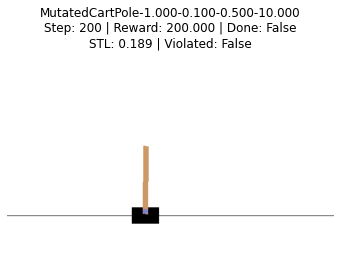

In [9]:
evaluate_dev(x_original, "gifs/default_env.gif")

### CMA for minimizing the STL robustness value given the bounded deviation

In [10]:
x = dev_violates_stl()

(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=787309, Fri Aug  5 10:48:28 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -2.500000069568836e-01 1.0e+00 4.39e-01  4e-01  5e-01 0:07.1


/home/cj/.pyenv/versions/3.8.10/envs/torch/lib/python3.8/site-packages/gym/envs/classic_control/cartpole.py:150: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  logger.warn(


termination on ftarget=0.0 (Fri Aug  5 10:48:35 2022)
final/bestever f-value = -2.500000e-01 -2.500000e-01
incumbent solution: [0.7736304628992363, 0.08802373296571714]
std deviation: [0.4304639097164025, 0.49944065449887337]
CMAEvolutionStrategyResult(xbest=array([0.77363046, 0.08802373]), fbest=-0.250000009934107, evals_best=7, evaluations=7, iterations=1, xfavorite=array([0.77363046, 0.08802373]), stds=array([0.43046391, 0.49944065]), stop={'ftarget': 0.0})


Deviation: [1.56989788 2.67245093]
Deviation distance: 7.349677477266431
Initial parameter: [-0.03108226 -0.02324924 -0.04498545 -0.03523275]
Min robustness value: -0.250000009934107


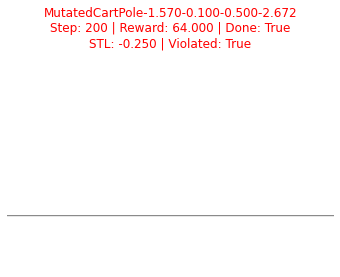

In [11]:
evaluate_dev(x, "gifs/counterexample.gif")

### CMA-ES for minimizing the deviation s.t. the STL is violated.

In [12]:
x = min_dev_violates_stl()


================ Trial 0 ==============>
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=839400, Fri Aug  5 10:48:51 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 2.436948896452727e-02 1.0e+00 2.55e-01  2e-01  3e-01 0:07.8
    2     12 3.577137487526704e-02 1.5e+00 2.12e-01  2e-01  3e-01 0:14.1
    3     18 1.022818451820760e+00 1.7e+00 3.00e-01  2e-01  6e-01 0:21.6
    4     24 4.811199806337401e+03 3.0e+00 2.65e-01  2e-01  5e-01 0:29.6
    5     30 7.820207077024304e+03 3.2e+00 2.72e-01  1e-01  6e-01 0:37.4
    6     36 8.373865336659530e+03 4.5e+00 2.42e-01  1e-01  5e-01 0:45.3
    7     42 1.755825808992788e+04 4.3e+00 2.08e-01  9e-02  3e-01 0:52.8
    8     48 2.520378793384131e+00 3.8e+00 1.49e-01  6e-02  2e-01 1:00.2
   10     60 1.498300850220285e+00 3.0e+00 1.56e-01  6e-02  2e-01 1:15.8
   12     72 8.990890100593050e-01 3.9e+00 9.73e-02  3e-02  1e-01 1:30.2
   14     84 9.505674555632492e-01 3.7e+00 6.28e-02  2e-02  5e-02 

   69    414 4.616874455470873e+00 3.5e+01 2.62e-03  9e-06  3e-04 5:25.7
   73    438 4.616670386446552e+00 3.4e+01 1.49e-03  4e-06  1e-04 5:54.1
   77    462 4.616955981118676e+00 4.6e+01 3.64e-03  8e-06  3e-04 6:20.6
   81    486 4.616958041429176e+00 4.1e+01 4.06e-03  7e-06  3e-04 6:47.7
   85    510 4.616829784918949e+00 3.9e+01 2.83e-03  6e-06  2e-04 7:14.5
   89    534 4.616553099067138e+00 4.8e+01 7.51e-03  1e-05  4e-04 7:42.3
   93    558 4.616279633377742e+00 6.2e+01 1.37e-02  2e-05  1e-03 8:10.9
   98    588 4.616527318940046e+00 4.0e+01 8.32e-03  1e-05  4e-04 8:44.5
  100    600 4.616378600518408e+00 4.0e+01 7.67e-03  1e-05  4e-04 8:58.1
  105    630 4.616658376231710e+00 6.8e+01 5.61e-03  8e-06  3e-04 9:33.3
  109    654 4.224692248096071e+00 7.0e+01 3.38e-03  3e-06  1e-04 10:01.7
termination on timeout=600.0 (Fri Aug  5 11:19:07 2022)
final/bestever f-value = 1.706172e+01 -1.029866e+02
incumbent solution: [0.9979760014628044, 0.23645035423571398]
std deviation: [0.00012406

Deviation: [ 0.10413923 10.01838851]
Deviation distance: 0.896049469276121
Initial parameter: [-0.0499989  -0.0436695  -0.04938519 -0.04435802]
Min robustness value: -0.0015836427639209782


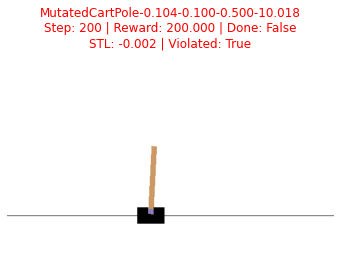

In [13]:
evaluate_dev(x, "gifs/min_dev_counterexample.gif")

### [Optional] CMA for finding the maximum deviation s.t. the agent is safe

In [14]:
x = max_safe_dev()


================ Trial 0 ==============>
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=821028, Fri Aug  5 11:19:22 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -4.134274121682624e+00 1.0e+00 1.97e-01  2e-01  2e-01 0:07.3
    2     12 -8.993011893426775e+00 1.4e+00 2.90e-01  2e-01  4e-01 0:12.4
    3     18 -7.071872920042402e+00 1.7e+00 3.00e-01  2e-01  3e-01 0:13.1
    4     24 -7.735504536594862e+00 1.7e+00 2.42e-01  2e-01  2e-01 0:19.3
    5     30 -7.548505359041932e+00 1.4e+00 4.03e-01  3e-01  5e-01 0:24.3
    6     36 -1.043934975537952e+01 1.8e+00 6.62e-01  4e-01  8e-01 0:31.5
    7     42 -1.002171497813921e+01 2.1e+00 8.27e-01  5e-01  9e-01 0:37.7
    9     54 -9.160200041783485e+00 2.3e+00 5.39e-01  2e-01  5e-01 0:49.8
   11     66 -1.106936792967230e+01 2.4e+00 4.37e-01  2e-01  3e-01 1:02.1
   13     78 -1.125136313205104e+01 1.7e+00 8.07e-01  4e-01  5e-01 1:15.7
   15     90 -1.022287236002569e+01 1.2e+00 9.38e-01  4e

termination on tolx=1e-05 (Fri Aug  5 11:43:46 2022)
final/bestever f-value = -1.019500e+01 -1.101073e+01
incumbent solution: [0.9999999999982309, 0.9999999999973306]
std deviation: [9.100708056849981e-06, 1.5216674156793035e-06]
CMAEvolutionStrategyResult(xbest=array([0.59110871, 0.99997189]), fbest=-11.010728230195042, evals_best=100, evaluations=421, iterations=70, xfavorite=array([1., 1.]), stds=array([9.10070806e-06, 1.52166742e-06]), stop={'tolx': 1e-05})
{'x': array([1., 1.]), 'f': -10.04987562112044, 'g': [-0.18914555807607536], 'f_al': -10.195000602266036, 'g_al': [-0.14512498114559608], 'count': 403}


Is safe!
Deviation: [ 2. 20.]
Deviation distance: 10.04987562112044
Initial parameter: [-0.04969433 -0.02805251 -0.04998818 -0.04905698]
Min robustness value: 0.18915986319082145


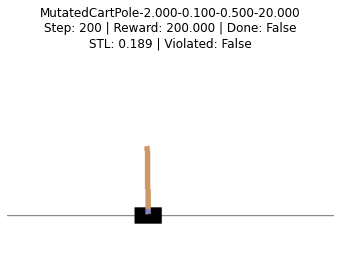

In [15]:
evaluate_dev(x, "gifs/max_safe_deviation.gif")

### Plot the shape of the optimization space using grid

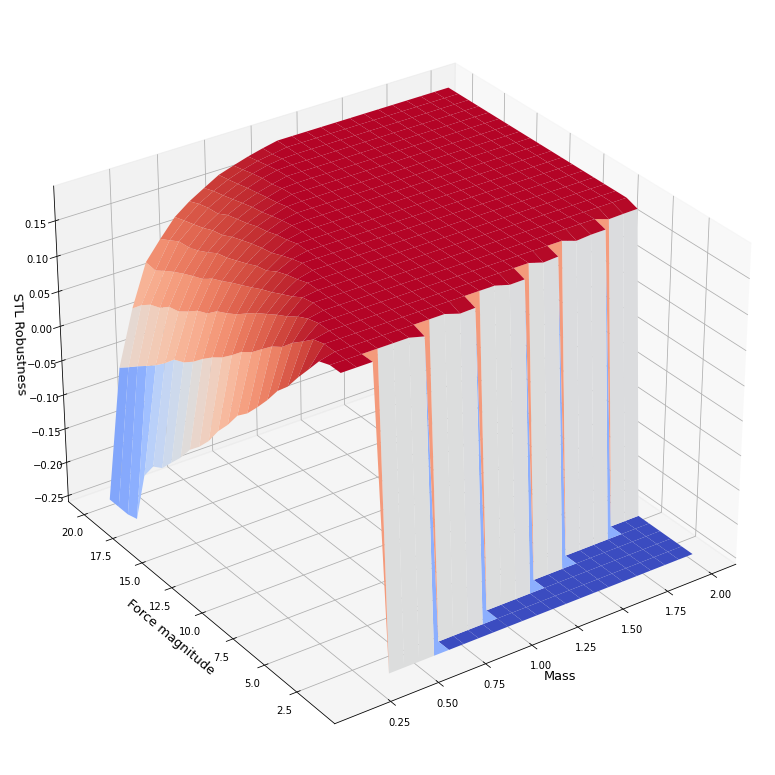

In [16]:
stl_falsify_target = -np.inf
ax, masses, forces, grid_data = grid_plot(masscart, force_mag, 25, 25, x_name="masses", y_name="forces")
ax.set_xlabel('Mass', fontsize=13)
ax.set_ylabel('Force magnitude', fontsize=13)
ax.view_init(30, -125)
plt.savefig('gifs/robustness-landscape.png')
plt.show()

### Using accelaration to understand the plot

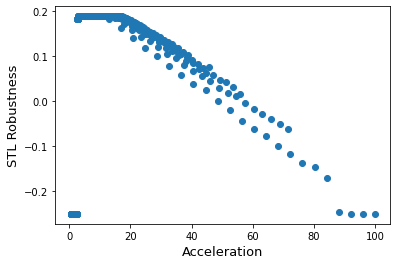

In [17]:
acc = forces / (masses + 0.1)
plt.scatter(acc.flatten(), grid_data.flatten())
plt.xlabel('Acceleration', fontsize=13)
plt.ylabel('STL Robustness', fontsize=13)
plt.savefig('gifs/robustness-landscape-acc.png')

### Zoom in the plot

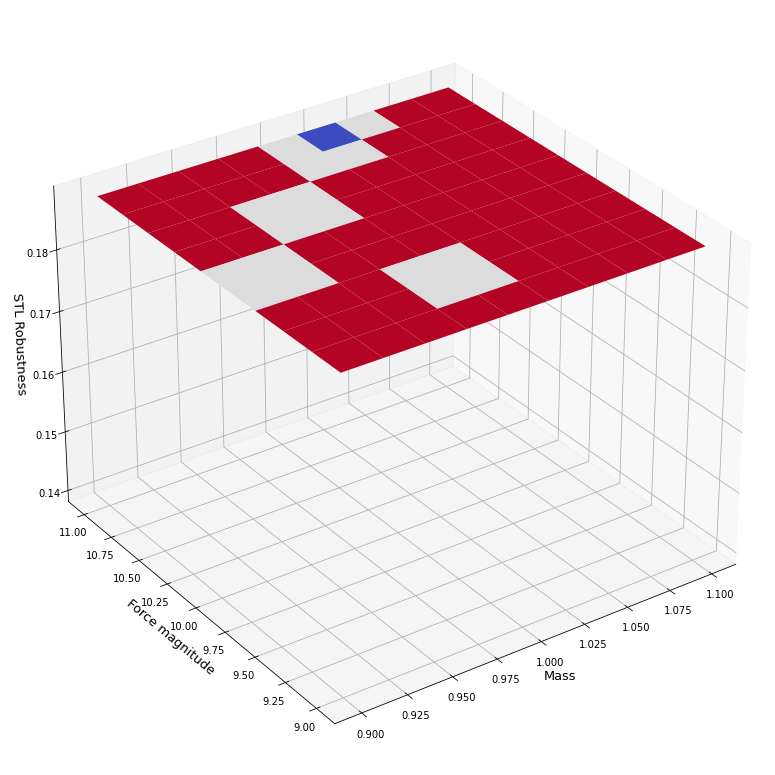

In [18]:
stl_falsify_target = -np.inf
ax, masses, forces, grid_data = grid_plot(masscart, force_mag, 25, 25,
                                          x_name="masses_zoomin", y_name="forces_zoomin",
                                          grid_name="grid_data_zoomin")
ax.set_xlabel('Mass', fontsize=13)
ax.set_ylabel('Force magnitude', fontsize=13)
ax.set_zlim(grid_data.max()-0.05, grid_data.max())
ax.view_init(30, -125)
plt.savefig('gifs/robustness-landscape-zoomin.png')
plt.show()